In [1]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl



# 引入Kalman函数库
from pykalman import KalmanFilter

# 引入纯随机序列检测，只有是非纯随机序列，才能进行检测
from statsmodels.stats.diagnostic import acorr_ljungbox

# 引入时序分析模型进行模型匹配
from statsmodels.tsa.arima_model import ARMA

import itertools

# 研究中建立回测（需要的策略中提前完成策略编写）
通过设置不同的参数后建立回测数据，通过回测数据计算因子载荷

In [3]:
#需要自己设置的参数,False/True参数传过去显示没法序列化，但是直接用{}传过去没问题

paramNames=['factor','group']
paramList=[['market_cap'],[1,10]]
algorithmID='85a3023da4d41d18f99f6663fc205457'
startDate='2008-01-01'
endDate='2018-11-30'
frequency='day'
initialCash=100000
maxBacktestNum=9 #最大同时回测数

params=list(itertools.product(*paramList))

df = pd.DataFrame(params,index=params,columns=paramNames)

created_bt_ids = []


for i in range(min(maxBacktestNum,df.shape[0])):
    var = df.iloc[i].to_dict()
    out_algorithm_id = create_backtest(algorithm_id=algorithmID, # id 需要自己拷贝
                        start_date=startDate, 
                        end_date=endDate, 
                        frequency=frequency, 
                        initial_cash=initialCash, 
                        initial_positions=None, 
                        extras= eval(str(var)),
                        name=str(var)
                        )
    
    gt = get_backtest(out_algorithm_id)
    
    while gt.get_status() != 'done':
        time.sleep(5)
        created_bt_ids.append(out_algorithm_id)
    


# 提取回测后的数据，组成Pandas数组


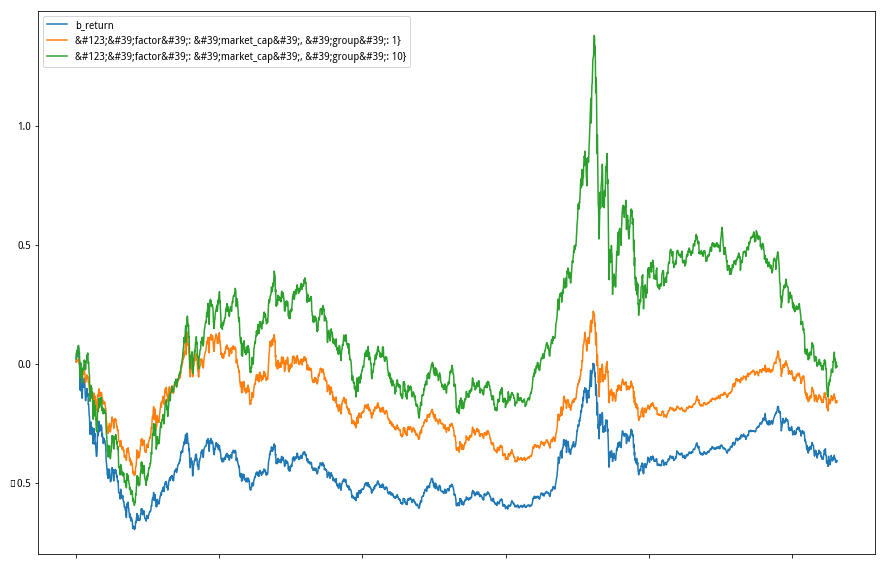

In [4]:
#先获取基准收益和交易日信息
gt = get_backtest(backtest_id = created_bt_ids[0])
res = gt.get_results()

b_return = []
t = []
for r in res:
    b_return.append(r['benchmark_returns'])
    t.append(r['time'])

#建立df存储数据   
factor_data_pd = pd.DataFrame(index = t)
factor_data_pd['b_return'] = b_return

#填入不同参数下的收益数据
for i in range(len(created_bt_ids)):
    gt = get_backtest(backtest_id = created_bt_ids[i])
    res = gt.get_results()
    name = gt.get_params()['name'] 
    s_return = []
    for r in res:
        s_return.append(r['returns'])

    factor_data_pd[name] = s_return

factor_data_pd.plot(figsize = (15,10))


In [ ]:
factor_data_pd.index = pd.to_datetime(factor_data_pd.index)
factor_data_pd.columns = ['bench_yield','yield_1st',"yield_2nd"]


In [ ]:

factor_data_pd['yield_1st_singleday'] = factor_data_pd['yield_1st'] - factor_data_pd['yield_1st'].shift(1)
factor_data_pd['yield_2nd_singleday'] = factor_data_pd['yield_2nd'] - factor_data_pd['yield_2nd'].shift(1)



In [ ]:
factor_data_pd = factor_data_pd.fillna(0)
factor_data_pd['month'] = np.array([d.strftime('%Y-%m') for d in factor_data_pd.index])


str(factor_data_pd.index.year) +'_'+ str(factor_data_pd.index.month)
factor_data_pd['yield_gap_singleday'] = np.log(1 + factor_data_pd['yield_1st_singleday'] - factor_data_pd['yield_2nd_singleday'])

factor_data_pd

In [ ]:
factor_load_series =  factor_data_pd.groupby('month')['yield_gap_singleday'].sum()


In [ ]:
factor_load_series = np.exp(factor_load_series) -1
factor_load_series

In [ ]:
np.mean(factor_load_series)

In [ ]:
np.std(factor_load_series)

# 合成代码，计算全量的因子载荷

In [2]:
# 明确代码
# 需要取倒数
factor_pool = ['pe_ratio','pe_ratio_lyr','pb_ratio','pcf_ratio']

# 因子库
factor_pool = ['market_cap','turnover_ratio',
               'roe','roa','inc_return','net_profit_margin','gross_profit_margin',
               'operating_expense_to_total_revenue',
               'expense_to_total_revenue','operation_profit_to_total_revenue',
               'invesment_profit_to_profit',
               'adjusted_profit_to_profit','goods_sale_and_service_to_revenue','ocf_to_revenue',
               'ocf_to_operating_profit','inc_total_revenue_annual','inc_total_revenue_year_on_year',
               'inc_revenue_year_on_year','inc_revenue_annual','inc_operation_profit_year_on_year',
               'inc_operation_profit_annual','inc_net_profit_year_on_year','inc_net_profit_annual',
               'inc_net_profit_to_shareholders_year_on_year','inc_net_profit_to_shareholders_annual'
              ]

# 存储结果的dict数组
result_factor_dict = {}

In [3]:
for factor_i in factor_pool:
    # 1、初始化结果dict
    result_factor_dict[factor_i] = []
    
    # 2、设置初始因子值，进行回测
    
    print("1、开始进行测算，因子值为：%s"%str(factor_i))
    
    paramList=[[factor_i],[1,10]]
    paramNames=['factor','group']
    algorithmID='85a3023da4d41d18f99f6663fc205457'
    startDate='2008-01-01'
    endDate='2018-11-30'
    frequency='day'
    initialCash=100000
    maxBacktestNum=9 #最大同时回测数

    params=list(itertools.product(*paramList))

    df = pd.DataFrame(params,index=params,columns=paramNames)

    created_bt_ids = []


    for i in range(min(maxBacktestNum,df.shape[0])):
        var = df.iloc[i].to_dict()
        out_algorithm_id = create_backtest(algorithm_id=algorithmID, # id 需要自己拷贝
                            start_date=startDate, 
                            end_date=endDate, 
                            frequency=frequency, 
                            initial_cash=initialCash, 
                            initial_positions=None, 
                            extras= eval(str(var)),
                            name=str(var)
                            )
        created_bt_ids.append(out_algorithm_id)
        
        gt = get_backtest(out_algorithm_id)

        while 1:
            if gt.get_status() == 'done':
                break
            elif gt.get_status() == 'none':
                time.sleep(5)
            elif gt.get_status() == 'failed':
                break
            elif gt.get_status() == 'running':
                time.sleep(5)
            elif gt.get_status() == 'canceled':
                break
            elif gt.get_status() == 'paused':
                break
            elif gt.get_status() == 'deleted':
                break                

        
        # 生成
        created_bt_ids.append(out_algorithm_id)
    
    
    print("2、完成回测")
    
    # 3、获取回测情况，生成数据
    gt = get_backtest(backtest_id = created_bt_ids[0])
    res = gt.get_results()

    b_return = []
    t = []
    for r in res:
        b_return.append(r['benchmark_returns'])
        t.append(r['time'])

    #建立df存储数据   
    factor_data_pd = pd.DataFrame(index = t)
    factor_data_pd['b_return'] = b_return

    #填入不同参数下的收益数据
    for i in range(len(created_bt_ids)):
        gt = get_backtest(backtest_id = created_bt_ids[i])
        res = gt.get_results()
        name = gt.get_params()['name'] 
        s_return = []
        for r in res:
            s_return.append(r['returns'])

        factor_data_pd[name] = s_return

    # 4、根据数据生成pandas数组
    factor_data_pd.index = pd.to_datetime(factor_data_pd.index)
    factor_data_pd.columns = ['bench_yield','yield_1st',"yield_2nd"]

    factor_data_pd['yield_1st_singleday'] = factor_data_pd['yield_1st'] - factor_data_pd['yield_1st'].shift(1)
    factor_data_pd['yield_2nd_singleday'] = factor_data_pd['yield_2nd'] - factor_data_pd['yield_2nd'].shift(1)
   
    factor_data_pd = factor_data_pd.fillna(0)
    factor_data_pd['month'] = np.array([d.strftime('%Y-%m') for d in factor_data_pd.index])


    factor_data_pd['yield_gap_singleday'] = np.log(1 + factor_data_pd['yield_1st_singleday'] - factor_data_pd['yield_2nd_singleday'])

    factor_load_series =  factor_data_pd.groupby('month')['yield_gap_singleday'].sum()

    factor_load_series = np.exp(factor_load_series) -1
    print("3、生成数据")
    # 5、加入对应的dict中
    result_factor_dict[factor_i].append(np.mean(factor_load_series))
    result_factor_dict[factor_i].append(np.std(factor_load_series))


1、开始进行测算，因子值为：market_cap
2、完成回测
3、生成数据
1、开始进行测算，因子值为：turnover_ratio
2、完成回测
3、生成数据
1、开始进行测算，因子值为：roe
2、完成回测
3、生成数据
1、开始进行测算，因子值为：roa
2、完成回测
3、生成数据
1、开始进行测算，因子值为：inc_return
2、完成回测
3、生成数据
1、开始进行测算，因子值为：net_profit_margin
2、完成回测
3、生成数据
1、开始进行测算，因子值为：gross_profit_margin
2、完成回测
3、生成数据
1、开始进行测算，因子值为：operating_expense_to_total_revenue
2、完成回测
3、生成数据
1、开始进行测算，因子值为：expense_to_total_revenue
2、完成回测
3、生成数据
1、开始进行测算，因子值为：operation_profit_to_total_revenue
2、完成回测
3、生成数据
1、开始进行测算，因子值为：invesment_profit_to_profit
2、完成回测
3、生成数据
1、开始进行测算，因子值为：adjusted_profit_to_profit
2、完成回测
3、生成数据
1、开始进行测算，因子值为：goods_sale_and_service_to_revenue
2、完成回测
3、生成数据
1、开始进行测算，因子值为：ocf_to_revenue
2、完成回测
3、生成数据
1、开始进行测算，因子值为：ocf_to_operating_profit
2、完成回测
3、生成数据
1、开始进行测算，因子值为：inc_total_revenue_annual
2、完成回测
3、生成数据
1、开始进行测算，因子值为：inc_total_revenue_year_on_year
2、完成回测
3、生成数据
1、开始进行测算，因子值为：inc_revenue_year_on_year
2、完成回测
3、生成数据
1、开始进行测算，因子值为：inc_revenue_annual
2、完成回测
3、生成数据
1、开始进行测算，因子值为：inc_operation_profit_year_on_year
2、完成回测
3、生成数据
1、开

In [4]:
result_factor_dict

{'market_cap': [0.020133739661669033, 0.10619921071772487],
 'turnover_ratio': [0.005348461918273817, 0.04737995174379009],
 'roe': [-0.007826553648093225, 0.04716599666619958],
 'roa': [-0.005685215595149367, 0.032480916212601546],
 'inc_return': [-0.008876636444735813, 0.050676474213902166],
 'net_profit_margin': [-0.0033644565455025564, 0.027814330562264192],
 'gross_profit_margin': [-0.005518021560964918, 0.03244947644422543],
 'operating_expense_to_total_revenue': [-0.004218499923921233,
  0.03544440302730587],
 'expense_to_total_revenue': [0.0037011172199758954, 0.030355736350493278],
 'operation_profit_to_total_revenue': [-0.003178592559381104,
  0.026991683977787034],
 'invesment_profit_to_profit': [-0.0006213721373961203, 0.023612043993849786],
 'adjusted_profit_to_profit': [-0.001540016991798263, 0.020365769738843895],
 'goods_sale_and_service_to_revenue': [-0.0017381933685940796,
  0.02775595989355203],
 'ocf_to_revenue': [-0.0006094358868397687, 0.028548081348039895],
 'ocf

In [5]:
result_factor_pd = pd.DataFrame.from_dict(result_factor_dict, orient='index')
result_factor_pd.to_csv('result__factor_pd.csv')

In [6]:
result_factor_pd

,0,1
market_cap,0.020134,0.106199
turnover_ratio,0.005348,0.047380
roe,-0.007827,0.047166
roa,-0.005685,0.032481
inc_return,-0.008877,0.050676
net_profit_margin,-0.003364,0.027814
gross_profit_margin,-0.005518,0.032449
operating_expense_to_total_revenue,-0.004218,0.035444
expense_to_total_revenue,0.003701,0.030356
operation_profit_to_total_revenue,-0.003179,0.026992


# 版本三：取出相应的因子载荷时间序列

In [19]:
# 明确代码
# 需要取倒数
factor_pool = ['pe_ratio','pe_ratio_lyr','pb_ratio','pcf_ratio']

# 因子库
factor_pool = ['market_cap','turnover_ratio',
               'roe','roa','inc_return','net_profit_margin','gross_profit_margin',
               'operating_expense_to_total_revenue',
               'expense_to_total_revenue','operation_profit_to_total_revenue',
               'invesment_profit_to_profit',
               'adjusted_profit_to_profit','goods_sale_and_service_to_revenue','ocf_to_revenue',
               'ocf_to_operating_profit','inc_total_revenue_annual','inc_total_revenue_year_on_year',
               'inc_revenue_year_on_year','inc_revenue_annual','inc_operation_profit_year_on_year',
               'inc_operation_profit_annual','inc_net_profit_year_on_year','inc_net_profit_annual',
               'inc_net_profit_to_shareholders_year_on_year','inc_net_profit_to_shareholders_annual'
              ]

# 存储结果的dict数组
result_factor_pd = pd.DataFrame()

In [20]:
for factor_i in factor_pool[0:2]:
    # 1、初始化结果dict
    # 不用初始化
    
    # 2、设置初始因子值，进行回测
    
    print("1、开始进行测算，因子值为：%s"%str(factor_i))
    
    paramList=[[factor_i],[1,10]]
    paramNames=['factor','group']
    algorithmID='85a3023da4d41d18f99f6663fc205457'
    startDate='2008-01-01'
    endDate='2018-11-30'
    frequency='day'
    initialCash=5000000
    maxBacktestNum=9 #最大同时回测数

    params=list(itertools.product(*paramList))

    df = pd.DataFrame(params,index=params,columns=paramNames)

    created_bt_ids = []


    for i in range(min(maxBacktestNum,df.shape[0])):
        var = df.iloc[i].to_dict()
        out_algorithm_id = create_backtest(algorithm_id=algorithmID, # id 需要自己拷贝
                            start_date=startDate, 
                            end_date=endDate, 
                            frequency=frequency, 
                            initial_cash=initialCash, 
                            initial_positions=None, 
                            extras= eval(str(var)),
                            name=str(var)
                            )
        created_bt_ids.append(out_algorithm_id)
        
        gt = get_backtest(out_algorithm_id)

        while 1:
            if gt.get_status() == 'done':
                break
            elif gt.get_status() == 'none':
                time.sleep(5)
            elif gt.get_status() == 'failed':
                break
            elif gt.get_status() == 'running':
                time.sleep(5)
            elif gt.get_status() == 'canceled':
                break
            elif gt.get_status() == 'paused':
                break
            elif gt.get_status() == 'deleted':
                break                

        
        # 生成
        created_bt_ids.append(out_algorithm_id)
    
    
    print("2、完成回测")
    
    # 3、获取回测情况，生成数据
    gt = get_backtest(backtest_id = created_bt_ids[0])
    res = gt.get_results()

    b_return = []
    t = []
    for r in res:
        b_return.append(r['benchmark_returns'])
        t.append(r['time'])

    #建立df存储数据   
    factor_data_pd = pd.DataFrame(index = t)
    factor_data_pd['b_return'] = b_return

    # 填入不同参数下的收益数据
    # 这个循环是在同一个factor下面获取不同的group值
    for i in range(len(created_bt_ids)):
        gt = get_backtest(backtest_id = created_bt_ids[i])
        res = gt.get_results()
        name = gt.get_params()['name'] 
        s_return = []
        for r in res:
            s_return.append(r['returns'])

        factor_data_pd[name] = s_return

    # 4、根据数据生成pandas数组
    factor_data_pd.index = pd.to_datetime(factor_data_pd.index)
    factor_data_pd.columns = ['bench_yield','yield_1st',"yield_2nd"]

    factor_data_pd['yield_1st_singleday'] = factor_data_pd['yield_1st'] - factor_data_pd['yield_1st'].shift(1)
    factor_data_pd['yield_2nd_singleday'] = factor_data_pd['yield_2nd'] - factor_data_pd['yield_2nd'].shift(1)
   
    factor_data_pd = factor_data_pd.fillna(0)
    factor_data_pd['month'] = np.array([d.strftime('%Y-%m') for d in factor_data_pd.index])


    factor_data_pd[factor_i] = np.log(1 + factor_data_pd['yield_1st_singleday'] - factor_data_pd['yield_2nd_singleday'])

    factor_load_series =  factor_data_pd.groupby('month')[factor_i].sum()

    factor_load_series = np.exp(factor_load_series) -1
        
    print("3、生成数据")
    
    # 5、加入对应的pandas中
    result_factor_pd = pd.concat([result_factor_pd,factor_load_series],axis = 1)

1、开始进行测算，因子值为：market_cap
2、完成回测
3、生成数据
1、开始进行测算，因子值为：turnover_ratio


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:109: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2、完成回测
3、生成数据


In [21]:
result_factor_pd.to_csv('result_factor_pd_by_month_no_reverse.csv')

,market_cap_gap,turnover_ratio_gap
month,,
2018-01,0.028866,-0.042884
2018-02,0.025791,0.031972
2018-03,0.001364,-0.003884
2018-04,0.005345,0.007722
2018-05,0.002393,0.006122
2018-06,-0.014391,-0.007012
2018-07,-0.002645,-0.021362
2018-08,-0.016929,0.030314
2018-09,0.011293,-0.015464


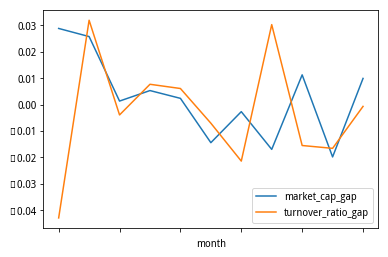

In [23]:
result_factor_pd.plot()